# Decode cypher text

### Welcome!
This notebook can decode cypher text. It uses a DFA created by the method outlined here
[Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576).

In this notebook will automatically train an RNN on symplfied set of english, and extract a DFA from that RNN.


# Code below

### 1. Imports

Implementations of LSTM and GRU classifiers, the main extraction method, and our own implenetations of DFACrawler, swapTracker, swapSuggester, FreqAnalysis, and rotationChecker

In [1]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Extraction import extract
import time
from memory_profiler import profile
import FalseWordGenerator as FWG

import ALPHABET_7
ALPHABET = ['e','t','a','o','s','i','n']

#from ALGO_CODE.swapController import swapTracker, swapSuggester
#from ALGO_CODE.decypherTools import DFACrawler, FreqAnalysis, rotationChecker

### 2. Training

#### 2.1. Define a Language
Here we provide examples of meaningful english words, and meaningless english words

In [2]:
MEANINGFUL_WORDS = ALPHABET_7.WORDS

MEANINGLESS_WORDS = FWG.generateFalseWords(ALPHABET, MEANINGFUL_WORDS)

def target(w):             
   if w.lower() in MEANINGFUL_WORDS:
      return True
   else:
      return False
    
print (MEANINGFUL_WORDS)
#alphabet = "etaoins" ##The RNN and DFA use this

['tense', 'tease', 'anoint', 'tone', 'tan', 'tie', 'inset', 'tin', 'tie', 'stain', 'tint', 'tone', 'season', 'set', 'tan', 'ionate', 'tense', 'sense', 'taste', 'see', 'test', 'anoint', 'assess', 'see', 'insist', 'assent', 'sass', 'insist', 'attest', 'assassinate', 'tease', 'test', 'tone', 'notate', 'state', 'note', 'intonate', 'set', 'tone', 'stet', 'station', 'sit', 'nose', 'test', 'tie', 'ante', 'seine', 'see', 'eat', 'toast', 'satiate', 'toe', 'set', 'soot', 'tie', 'stone', 'noose', 'tie', 'tee', 'tease', 'net', 'nest', 'tin', 'toe', 'toss', 'tease', 'see', 'tee', 'toe', 'nest', 'set', 'tease', 'sit', 'seat', 'tease', 'set', 'seat', 'set', 'initiate', 'tie', 'noose', 'tat', 'tattoo', 'sonnet', 'annotate', 'set', 'eat', 'tease', 'ease', 'nose', 'toe', 'set', 'nose', 'sit', 'see', 'note', 'see', 'attaint', 'sense', 'instantiate', 'see', 'taste', 'season', 'taste', 'stint', 'net', 'assess', 'seat', 'sanitate', 'initiate', 'assist', 'tenant', 'assassinate', 'see', 'test', 'sin', 'stet',

In [3]:
print(target("IS"))
print(target("EAT"))
print(target("TINS"))
print(target('NOT'))
print(target('TEST'))
print(target('TAPE'))

False
True
False
True
True
False


#### 2.2. Create a Train Set

train_set is automatically filled out with meaningfully words, meaningless words, and their classificatation values

In [16]:
#meaningfullClass = [word for word in MEANINGFUL_WORDS]
#meaninglessClass = [word for word in MEANINGLESS_WORDS]
startingExamples = MEANINGFUL_WORDS + MEANINGLESS_WORDS
#train_set = make_train_set_for_target(target,ALPHABET, provided_examples = startingExamples)
#train_set = meaningfullClass + meaninglessClass
train_set = {}
train_set.update({w: True for w in MEANINGFUL_WORDS})
train_set.update({w: False for w in MEANINGLESS_WORDS})
print ("made training set of size: " + str(len(train_set)))
print ("of which " + str(len(MEANINGFUL_WORDS)) + str(" are positive"))
print ("of which " + str(len(MEANINGLESS_WORDS)) + str(" are negative"))

made training set of size: 1371
of which 1023 are positive
of which 963 are negative


In [17]:
print(len(train_set))
#print (train_set)
print (type(train_set))
print(list(train_set.items())[:10])

1371
<class 'dict'>
[('tense', True), ('tease', True), ('anoint', True), ('tone', True), ('tan', True), ('tie', True), ('inset', True), ('tin', True), ('stain', True), ('tint', True)]


#### 2.3. Create and Train a Network


`RNNClassifier` generates an RNN-Classifier for a given alphabet.
Its optional parameters are:
>1. `num_layers` (default value 2): the number of hidden layers
>2. `hidden_dim` (default value 5): the size of the hidden layers
>3. `input_dim` (default value 3): the size of the input vectors (these networks use embedding, not one-hot encoding)
>4. `RNNClass` (default value `LSTMNetwork`): the RNN architecture (possible values `LSTMNetwork`, `GRUNetwork`)

In [18]:
#rnnDeep = RNNClassifier(ALPHABET,num_layers=2,hidden_dim=50,RNNClass = LSTMNetwork)
#rnnWide = RNNClassifier(ALPHABET,num_layers=5,hidden_dim=5,RNNClass = LSTMNetwork)
#rnnLarge = RNNClassifier(ALPHABET,num_layers=5,hidden_dim=50,RNNClass = LSTMNetwork)
rnnSmall = RNNClassifier(ALPHABET,num_layers=2,hidden_dim=5,RNNClass = LSTMNetwork)

The function `mixed_curriculum_train(rnn,train_set)` trains the network `rnn` with the given dictionary of labeled examples, `train_set`. Its optional parameters are: 
>1. `stop_threshold` (default $0.001$): the threshold for the average loss of the network on the train set under which training is cut short
>2. `learning_rate` (defualt 0.001): learning rate for optimiser
>2. `length_epochs` (default $5$): explained below
>3. `random_batch_epochs` (default $100$): below
>4. `random_batch_size` (default $20$): below
>5. `single_batch_epochs` (default $100$): below
>6. `outer_loops` (default $3$): below

`mixed_curriculum_train` splits the input dictionary first into batches by length, training for `length_epochs` iterations each of these batches, by order of increasing length. Then for `random_batch_epochs` iterations it will, at each iteration, split the dictionary into random batches of size `random_batch_size` and train each batch for one iteration. After that it will train the dictionary as one big batch for `single_batch_epochs` iterations. It does all of this `outer_loops` times.

This will print some scatter plots of the average loss on the train set. The plots will come in pairs: each time one for the most recent iterations of training where the whole dictionary was trained as one batch, and another for all the iterations the rnn has been trained since its initialisation.

`mixed_curriculum_train` should work for most simple targets without any tinkering. If the network doesn't drop under the stop threshold, you may want to call it again.

current average loss is:  0.20323550657556927
current average loss is:  0.19638536030203296
current average loss is:  0.19960866652929735
current average loss is:  0.18980694491715622
current average loss is:  0.1840826889350323


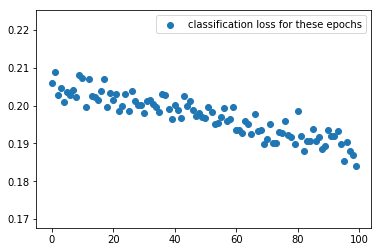

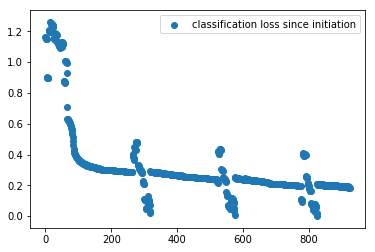

current average loss is:  0.1758354515337231
current average loss is:  0.17229648092034783
current average loss is:  0.16832439887271494
current average loss is:  0.1643706696647349
current average loss is:  0.1606031511057736


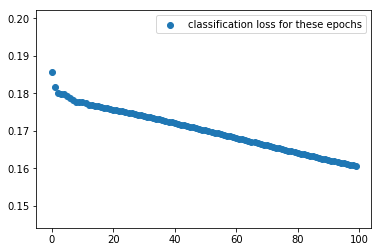

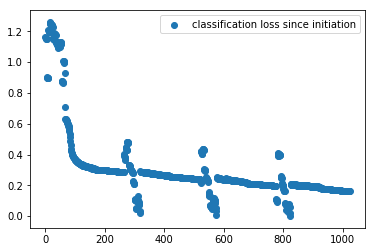

current average loss is:  0.1672380218235715
current average loss is:  0.16188636355210043
current average loss is:  0.15971682647805122
current average loss is:  0.15429523771380876
current average loss is:  0.15604840599501088


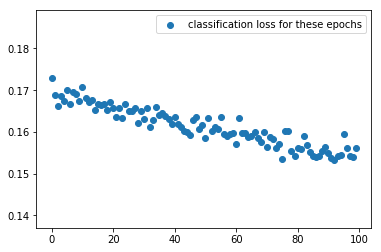

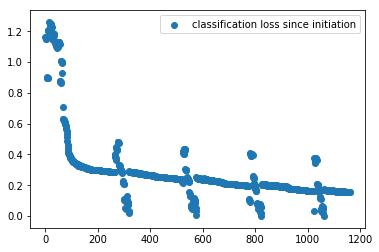

current average loss is:  0.1408903983107107
current average loss is:  0.13690560617036493
current average loss is:  0.13330813796741087
current average loss is:  0.13040184505137103
current average loss is:  0.12778819589872242


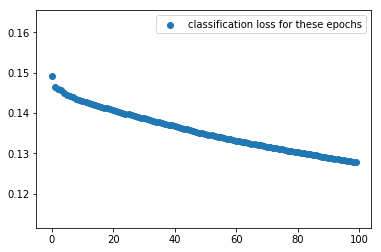

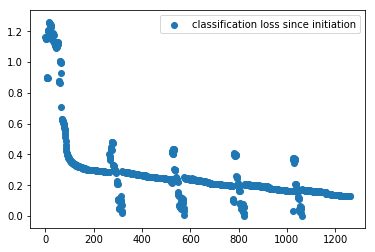

current average loss is:  0.13879886406212458
current average loss is:  0.13627298833196186
current average loss is:  0.13576107398558984
current average loss is:  0.1274982836794437
current average loss is:  0.12587747843212133


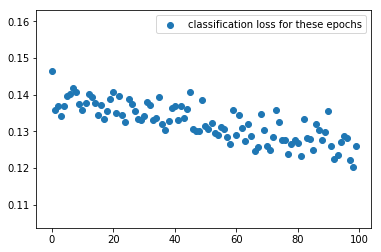

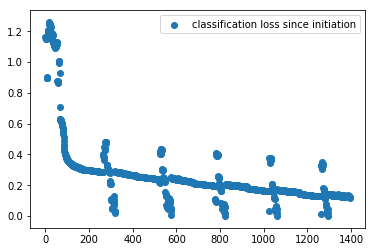

current average loss is:  0.1063268815923311
current average loss is:  0.10245603509926604
current average loss is:  0.09867021934904381
current average loss is:  0.09519853877116954
current average loss is:  0.09212271859400643


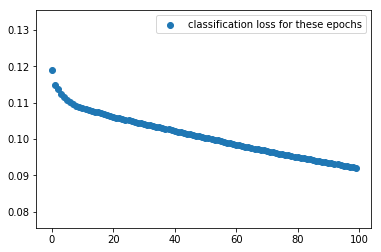

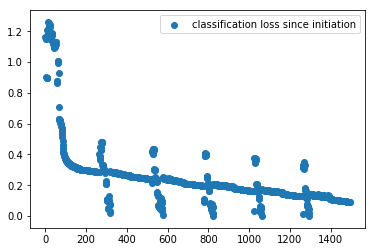

classification loss on last batch was: 0.09212271859400643


In [20]:
#mixed_curriculum_train(rnnDeep,train_set,stop_threshold = 0.05)
#mixed_curriculum_train(rnnWide,train_set,stop_threshold = 0.05)
#mixed_curriculum_train(rnnLarge,train_set,stop_threshold = 0.05)
mixed_curriculum_train(rnnSmall,train_set,stop_threshold = 0.05)
#Small network was 0.19 accuracy

### 3. Extraction

#### 3.1. Initial Examples

In Section 7.3 of the paper we note that the process sometimes needs one positive and one negative initial sample to get started. We take these from the training set, using the shortest sample from each class.

If extracting from a network you no longer have the train set for, you can also make such a list manually. 
Of course, there is nothing to stop you from having more than one initial sample from each class, or not using any, and so on.

In [10]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnnSmall.classify_word(w)==True),None)
neg = next((w for w in all_words if rnnSmall.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]
print(starting_examples)
starting_examples = ['test', 'not']
print(starting_examples)

['o', 'i']
['test', 'not']


#### 3.2. Clear the Computation Graph
If you're using our network classes, and just running one network at a time, you don't need this. Still, it's good practice. `renew` function resets the DyNet computation graph and refreshes the calling network's initial vectors.

In [11]:
rnnSmall.renew()
#rnnLarge.renew()
#rnnDeep.renew()
#rnnWide.renew()

#### 3.3. Extract
It is generally necessary to give the extraction some `starting_examples` to work with, so it doesn't get stuck on a single state automaton (Section 7.3. in the paper). We made those in Section 3.1. of this notebook.

You can set a `time_limit` on the extraction (default $50$ seconds) and the `initial_split_depth` (default $10$) for the initial aggressive refinement (which is described in Section 7.3.1. of our extraction paper).


During extraction, the method will report the counterexamples it finds, how long it took to find each one, and how long it took to refine the observation table (i.e. how long it took to update the $L^*$ automaton) between each two equivalence queries. Every time it starts a new equivalence query, if the proposed DFA has less than $30$ states, it will also display it.

provided counterexamples are: ['test', 'not']
obs table refinement took 0.0
guided starting equivalence query for DFA of size 2


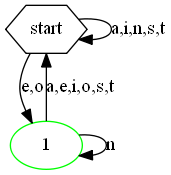

storing provided counterexample of length 4
returning counterexample of length 4:		test, this counterexample is accepted by the given RNN.
equivalence checking took: 0.07099863799999184
obs table refinement took 0.076
guided starting equivalence query for DFA of size 14


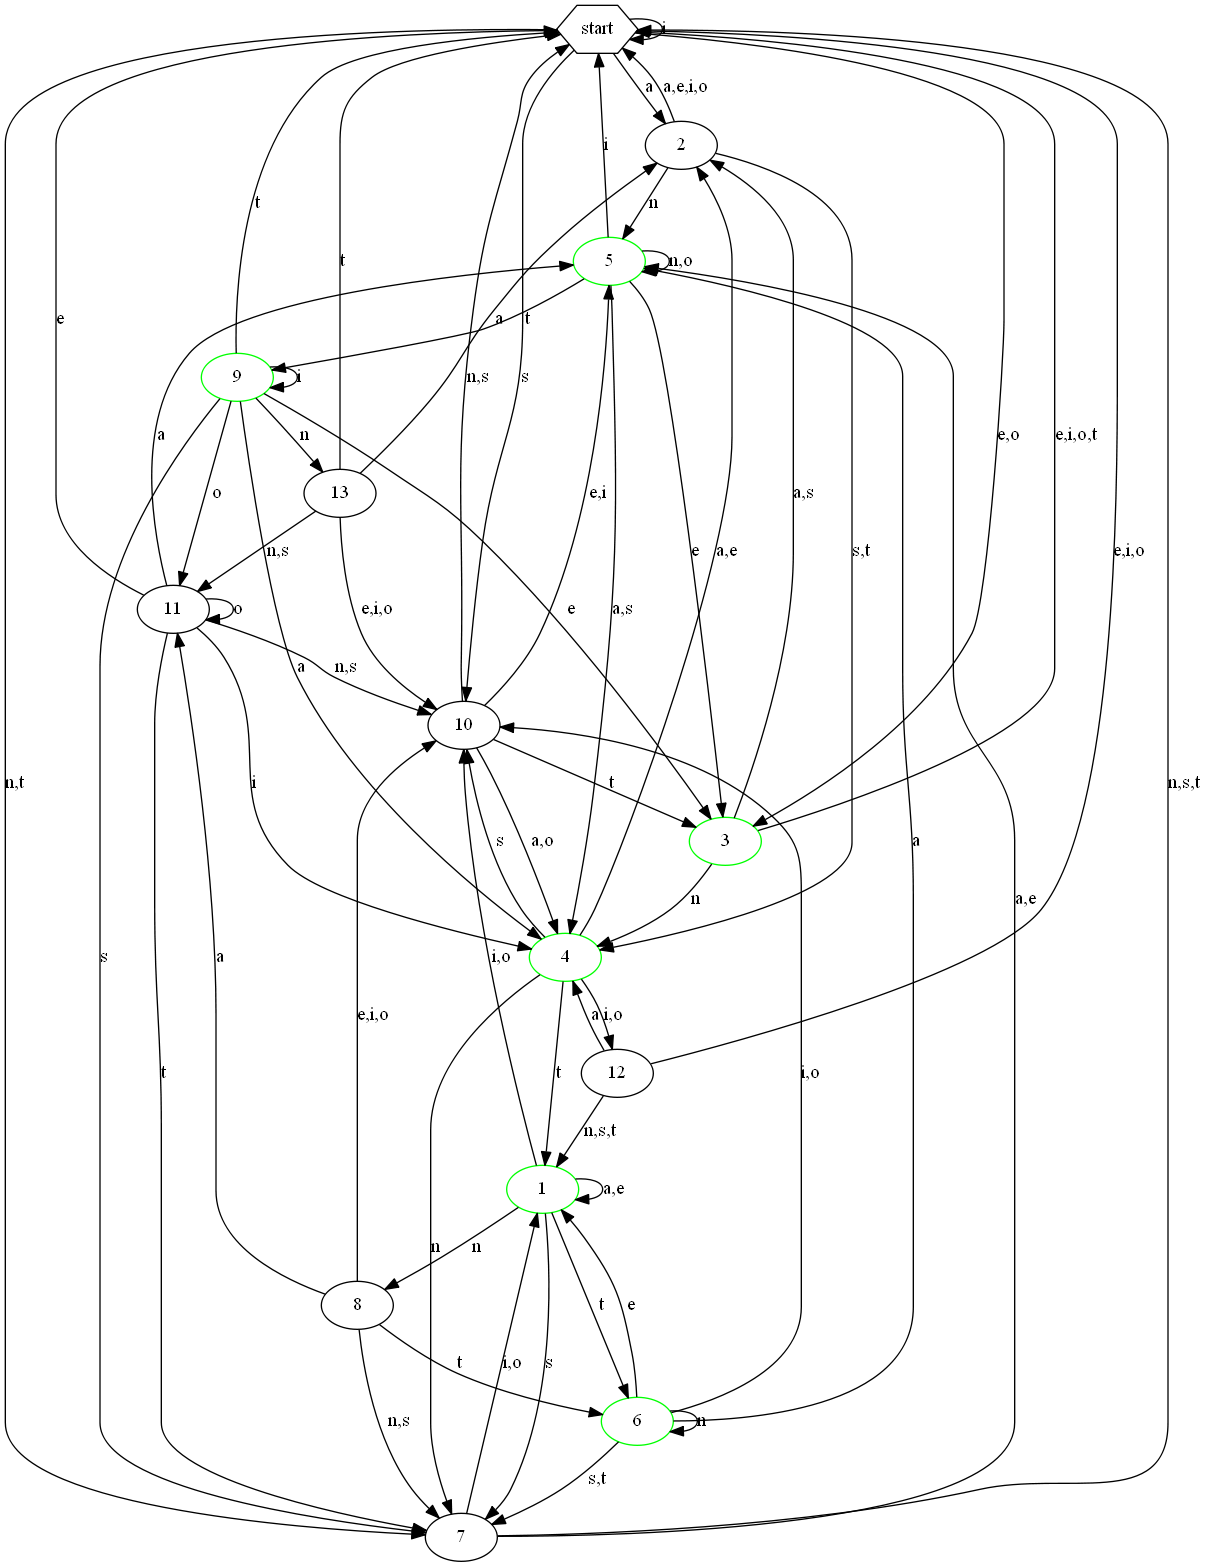

['', 'e']
refining, H size is 1
split wasn't perfect: gotta start over
['e', 'o']
['t', 'n']
['i', 'eo']
['i', 'eo', 'ei']
['es', 'en']
refining, H size is 1
['te', 'ta']
['te', 'ta', 'to']
returning counterexample of length 3:		tan, this counterexample is rejected by the given RNN.
equivalence checking took: 0.23484457699998984
obs table refinement took 0.18
guided starting equivalence query for DFA of size 24


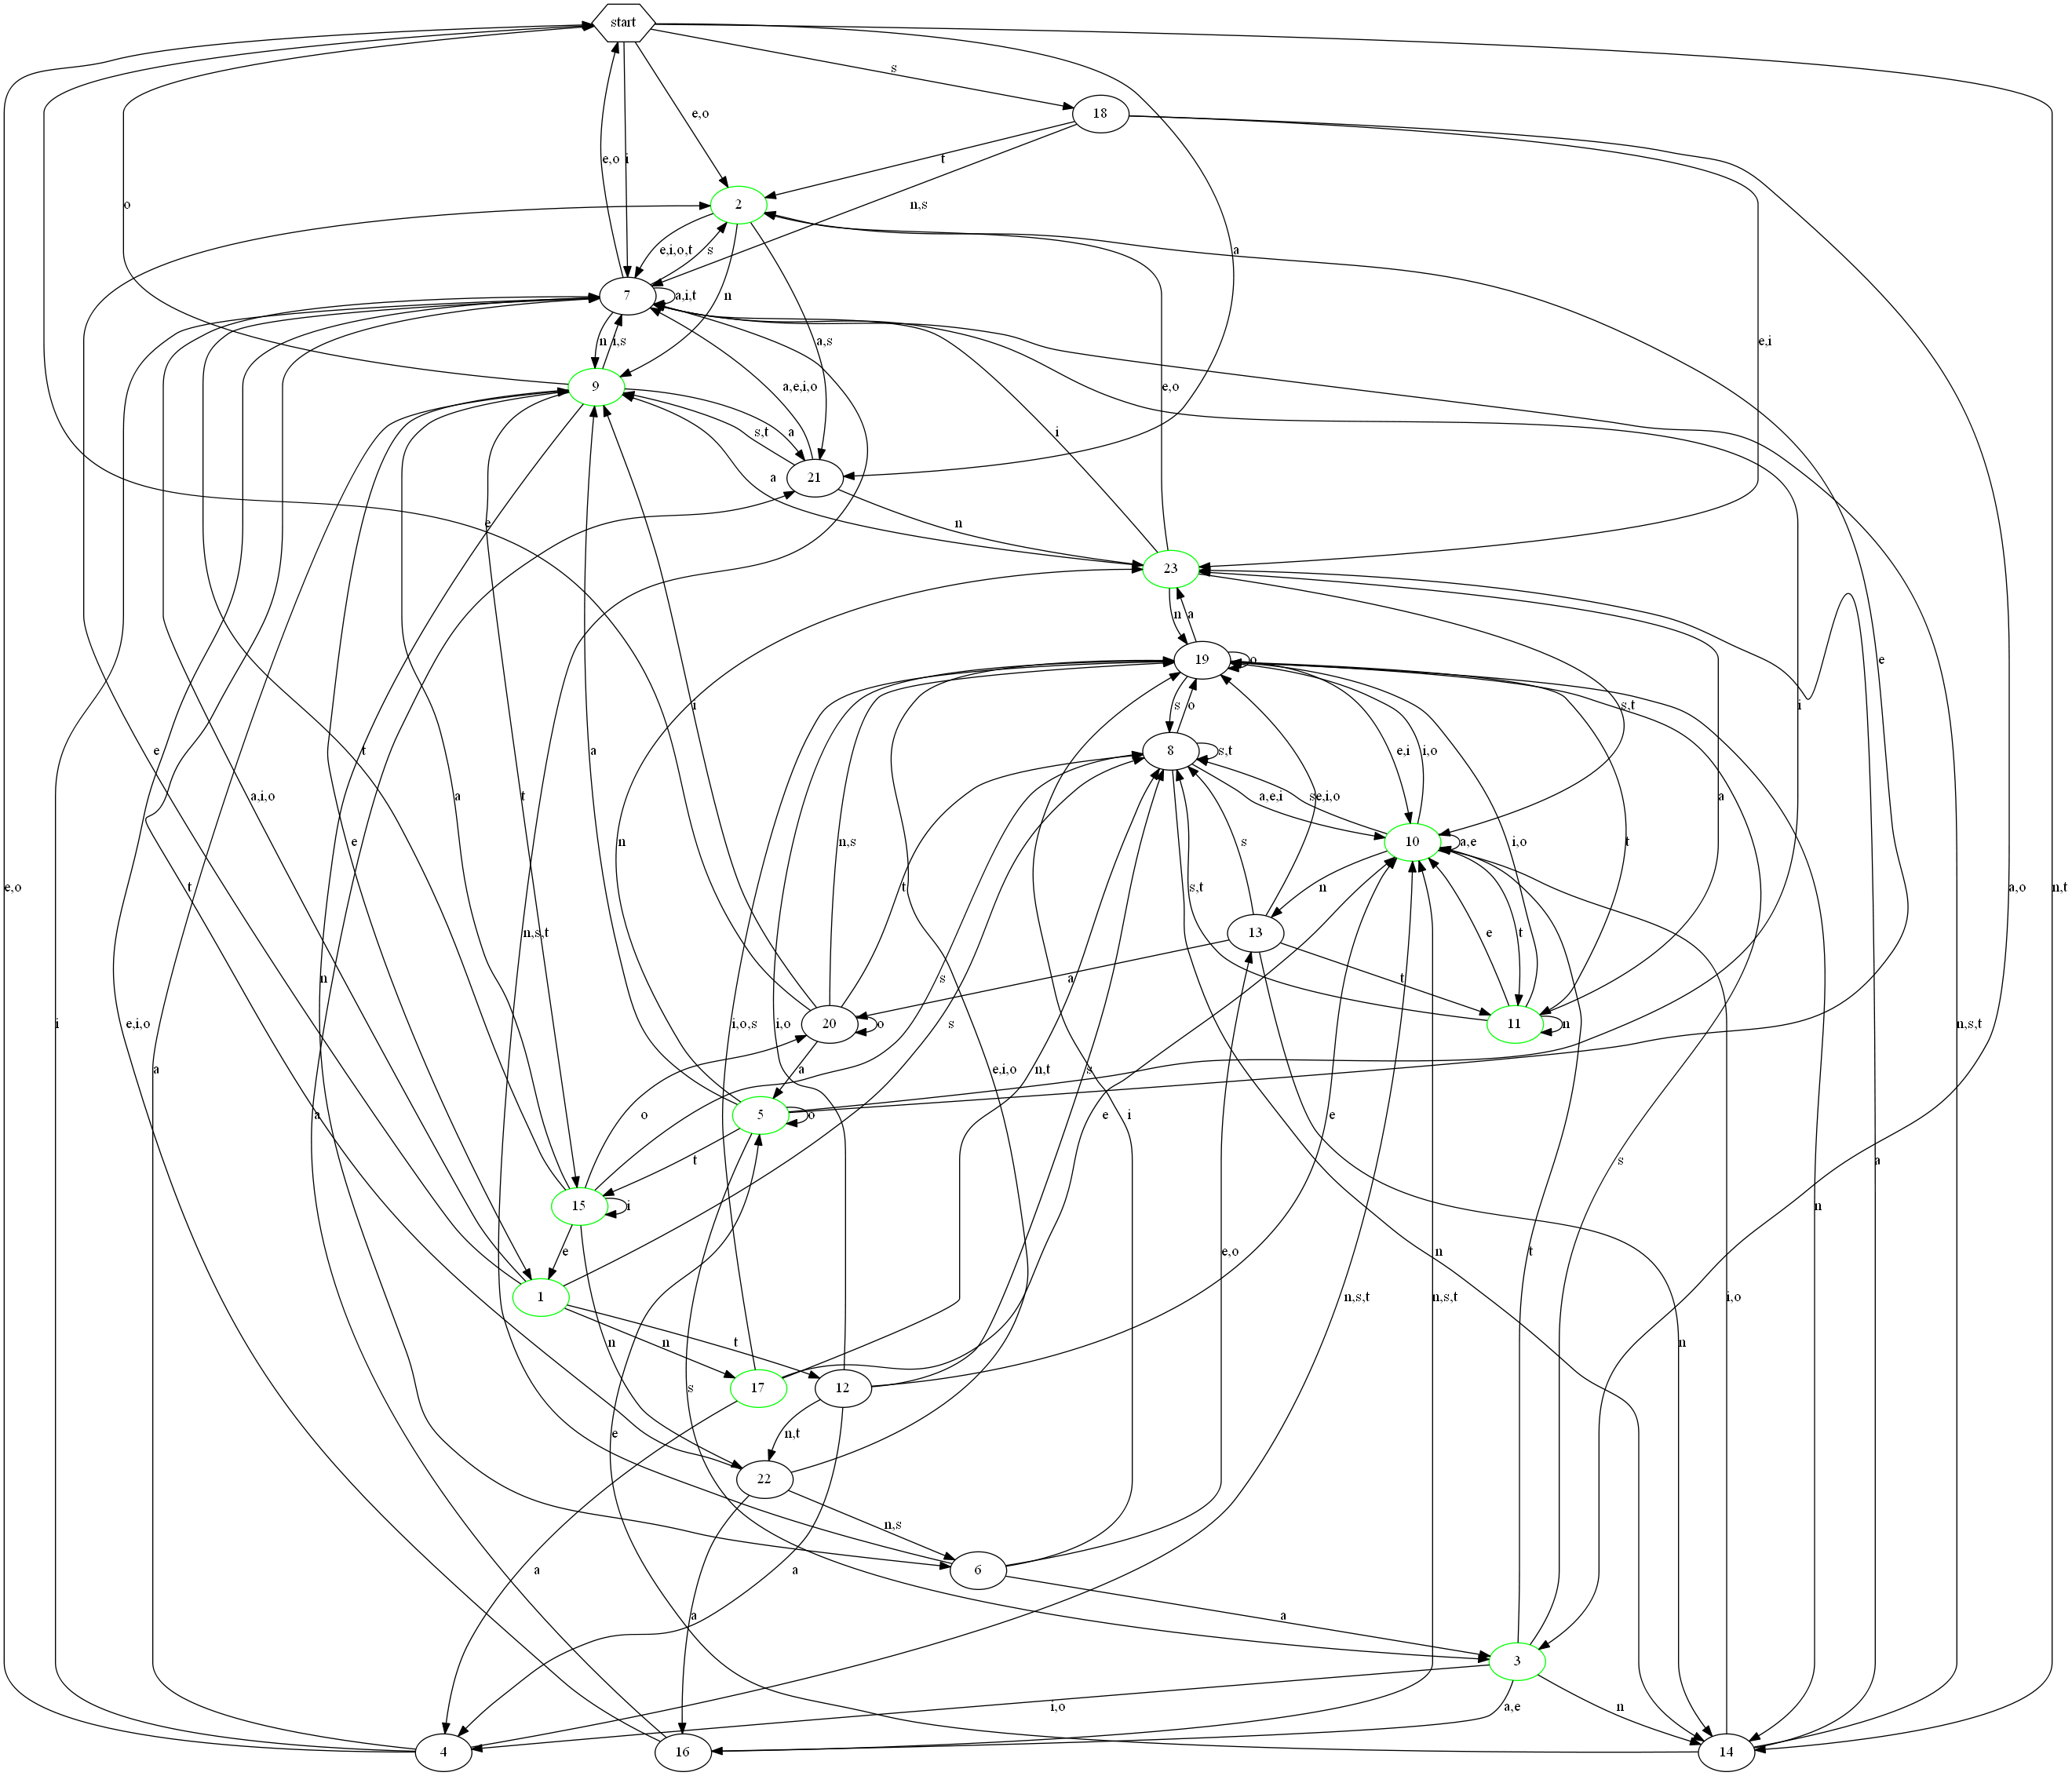

['e', 'o']
['t', 'n']
['i', 'eo']
['i', 'eo', 'ei']
['te', 'ta']
returning counterexample of length 4:		teoe, this counterexample is rejected by the given RNN.
equivalence checking took: 0.6823513989999981
obs table refinement took 0.862
guided starting equivalence query for DFA of size 79
['e', 'o']
['t', 'n']
returning counterexample of length 4:		neos, this counterexample is accepted by the given RNN.
equivalence checking took: 0.002893413999998984
obs table refinement took 3.555
guided starting equivalence query for DFA of size 166
['e', 'o']
['t', 'n']
returning counterexample of length 3:		nts, this counterexample is rejected by the given RNN.
equivalence checking took: 0.002700008999994452
obs table refinement took 15.654
guided starting equivalence query for DFA of size 367
['e', 'o']
refining, H size is 1
['t', 'n']
refining, H size is 1
['i', 'eo']
returning counterexample of length 4:		eona, this counterexample is rejected by the given RNN.
equivalence checking took: 0.00651

NameError: name 'rnnLarge' is not defined

In [12]:
dfaSmall = extract(rnnSmall,time_limit = 600, initial_split_depth = 10, starting_examples = starting_examples)
#dfaLarge = extract(rnnLarge,time_limit = 600, initial_split_depth = 10, starting_examples = starting_examples)
#dfaDeep = extract(rnnDeep,time_limit = 600, initial_split_depth = 10, starting_examples = starting_examples)
#dfaWide = extract(rnnWide,time_limit = 600, initial_split_depth = 10, starting_examples = starting_examples)

#### 3.4. Get stats
Display the extracted DFA by using the `draw_nicely` function, which has optional parameters `maximum` (default $60$) and `force` (default `False`), and will only draw the DFA if it has less than `maximum` states or `force` is set to `True`.

Print some statistics you might find interesting about the network, such as the trained RNN's accuracy against its target, the extracted DFA's accuracy against the RNN, and the extracted DFA's accuracy against the original RNN's target.

In [11]:
from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfa.draw_nicely(maximum=30) #max size willing to draw

test_set = train_set 
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")

NameError: name 'dfa' is not defined

Rotation Cypher Checker

In [12]:
def rtCyCdecode(message):  # Rotation cypher decode
    msgList = list(message.lower())
    letterList = ['a', 'e', 'i', 'n', 'o', 's', 't']
    convertedMsgList = []

    for i in range(1, len(letterList)):
        convertedMsg = ""
        for letter in msgList:
            lIndex = letterList.index(letter)
            newLIndex = (lIndex + i) % len(letterList)
            convertedMsg += letterList[newLIndex]
        convertedMsgList.append(convertedMsg)

    return convertedMsgList

In [13]:
@profile(precision=8)
def checkRNN(convertedMsgList):
    for convertedMsg in convertedMsgList:
        if rnn.classify_word(convertedMsg):
            print("Cyphered Message is English", convertedMsg, "in RNN")
            return True

In [14]:
@profile(precision=8)
def checkDFA(convertedMsgList):
    for convertedMsg in convertedMsgList:
        if dfa.classify_word(convertedMsg):
            print("Cyphered Message is English", convertedMsg, "in DFA")
            return True

In [15]:
def rtCyChecker(message):  # Rotation cypher checker
    convertedMsgList = rtCyCdecode(message)
    foundKeyRNN = False
    foundKeyDFA = False
    print("Try message in following list", '\n', convertedMsgList)

    startRNN = time.time()
    if checkRNN(convertedMsgList):
        foundKeyRNN = True
    executeTimeRNN = time.time() - startRNN
    print("RNN execution time", executeTimeRNN)

    startDFA = time.time()
    if checkDFA(convertedMsgList):
        foundKeyDFA = True
    executeTimeDFA = time.time() - startDFA
    print("DFA execution time", executeTimeDFA)

    if foundKeyRNN != foundKeyDFA:
        print("RNN and DFA returned different result")

    if not foundKeyRNN and not foundKeyDFA:
        print("No rotation cyphered message founded")

In [16]:
rtCyChecker(message)        # Call above functions

NameError: name 'message' is not defined